In [112]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%pylab inline
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from numpy.linalg import norm
from numpy import copy

from scipy.stats import probplot
import scipy as sp

from ipywidgets import FloatProgress
from IPython.display import display

import timeit

import fibonacci_heap_mod as fhm

from scipy.sparse import csr_matrix
from scipy import sparse

Populating the interactive namespace from numpy and matplotlib


## Постановка задачи

$$\begin{array}{lcl} f(x) = \frac{1}{2} \left\lVert Ax-y\right\rVert^{2} + \frac{\mu}{2} \left\lVert x\right\rVert^{2} \\
\nabla f(x) = \mu x + A^T  (Ax - y) \end{array}$$

Где $A$ -- плотная $m\cdot n$ матрица <br>
$y$ -- $m\cdot 1$ вектор ответов <br>
$x$ -- $n\cdot 1$ искомый вектор

Пусть:

$H = \widetilde{A}^T\widetilde{A} + \mu \widetilde{I}$

Где:

$\widetilde{A} = \begin{bmatrix} y & -X \end{bmatrix}$
$\widetilde{I} = \begin{bmatrix} 0 & 0 \\ 0 & I_n \end{bmatrix}$

Дополним пространство $D$ допустимых ответов как $\widetilde{D} = \{1\}\times D$, и перепишем исходную задачу как:

$\widetilde{f}(\beta) = \left(\widetilde{A}\beta\right)^T\left(\widetilde{A}\beta\right)^T + \beta^T\widetilde{I}\beta \to \min_\limits{\beta \in \widetilde{D}}$

Дифференцируя по $\beta$ получаем:

$\nabla \widetilde{f}(\beta) = H\beta$

Вводя $z_k = \frac{x_k}{b_k}$ сохраняя обозначения из статьи получаем, что:

$\arg \min H\beta_k \sim \arg\min H \begin{bmatrix}b_{k}^{-1} \\ z_k\end{bmatrix}$

## Тестирование алгоритма

Сгенерируем задачу

In [188]:
%%time

n = int(1e5)       # Размерность пространства. Осторожно: при порядке n = 10^8 памяти в 8 GB может не хватать
m = n              
mu = 1           # Коэффицент регуляризации в задаче Ridge
X = sparse.rand(m, n, density=5/n).tocsr()  # Матрица исходных данных Х размера [m*n], плотность = доля ненулевых эл-тов
x_true = sparse.rand(1, n, density=0.003).tocsr()  # Искомое решение             
x_true /= x_true.sum() # Решение живет на единичном симплексе
# Вектор Y ответов в регрессии искусственно делается всюду плотным плотным путем зашумления
y = X.dot(x_true.T) + sparse.rand(m, 1, density=1, format="csr")*0.000000000001 
print("%d non-zero elements in matrix X"%(len(X.nonzero()[1])))
print(x_true.count_nonzero(), "non-zero elements in x_true")
x0 = sparse.rand(1, n, density=1/n).tocsr() # Стартовая точка -- случайный угол симплекса

500000 non-zero elements in matrix X
300 non-zero elements in x_true
CPU times: user 1.83 s, sys: 90.4 ms, total: 1.92 s
Wall time: 2.02 s


Импортируем алгоритм из библиотеки (p.s. приветствуются предложения по имени для алгоритма)

In [158]:
from lib.optimization import noname_algorithm_ridge, noname_algorithm_lasso

Описание параметров алгоритма:

* X -- матрица исходных данных [m*n]
* y -- вектор ответов в регрессии
* mu -- коэффицент регуляризации
* x0 -- начальная точка
* e -- относительная точность по квадрату нормы градиента. Критерий останова: ||g(xk)|| < e*||g(x0)||
* mode = "heap" | "full_grad" -- способ выбора координаты спуска: в режиме heap алгоритм поддерживает кучу на компонентах градиента, в режиме "full_grad" алгоритм берет простой argmin по его компонентам на каждом шаге
* step = "constant" | "paraboluc" -- способ выбора длины шага: в режиме constant длина шага k задается формулой 1/(1+k), в режиме parabolic длина шага ищется из точки минимума параболического приближения
* k_max -- максимальное число итераций
* history_elements -- если не пусто, то алгоритм логирует свою работу. Все перечисленные статистики заносятся в соответствующий список на каждом шаге. В конце работы эти списки статистик возвращаются в переменной history.

На каждом шаге в соответствующую компоненту history заносятся следующие величины:
* "g_norm" -- норма градиента функции 
* "x_norm" -- норма решения
* "d_sparsity" -- число ненулевых элементов в апдейте градиента
* "x_sparsity" -- число ненулевых элементов в текущем х
* "gamma" -- длина шага
* "f" -- значение функции в точке
* "time" -- время работы от начала (без учета препроцессинга данных)

В качестве результата функция возвращает:
* x -- найденное решение
* message -- "success" | "iterations_exceeded" -- результат работы: успешное завершение поиска с заданной точностью, или же остановка при достижении предельного числа итераций

In [199]:
%%time
x, message, history = noname_algorithm_ridge(X, y, mu, x0, e = 1e-2, gradient_update_mode="heap", step="parabolic",
                                 k_max = 1e4,  history_elements=("g_norm","time","d_sparsity", "gamma", "x_sparsity", "x_norm"))
print(message)

success
CPU times: user 7min 49s, sys: 6.31 s, total: 7min 55s
Wall time: 8min 3s


In [200]:
%%time
x_fix, message, history_fix = noname_algorithm_ridge(X, y, mu, x0, e = 1e-2, gradient_update_mode="heap", step="constant",
                                 k_max = 1e4,  history_elements=("g_norm","time","d_sparsity", "gamma"))
print(message)

success
CPU times: user 8min 16s, sys: 3.11 s, total: 8min 19s
Wall time: 8min 22s


In [201]:
%%time
x_lasso, message_lasso, history_lasso = noname_algorithm_lasso(X, y, mu, x0, e = 1e-2, gradient_update_mode="heap", step="constant",
                                 k_max = 1e4,  history_elements=("g_norm","time","d_sparsity", "gamma", "x_sparsity"))
print(message)

success
CPU times: user 5min 1s, sys: 1.56 s, total: 5min 3s
Wall time: 5min 4s


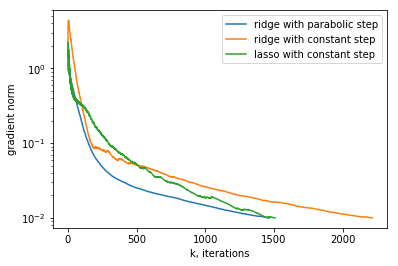

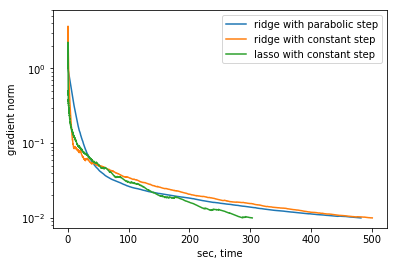

In [212]:
semilogy(range(len(history["time"])), history["g_norm"], label = "ridge with parabolic step")
semilogy(range(len(history_fix["time"])), history_fix["g_norm"], label = "ridge with constant step")
semilogy(range(len(history_lasso["time"])), history_lasso["g_norm"], label = "lasso with constant step")
legend()
xlabel("k, iterations")
ylabel("gradient norm")

show()

semilogy(history["time"], history["g_norm"], label = "ridge with parabolic step")
semilogy(history_fix["time"], history_fix["g_norm"], label = "ridge with constant step")
semilogy(history_lasso["time"], history_lasso["g_norm"], label = "lasso with constant step")
legend()
xlabel("sec, time")
ylabel("gradient norm")

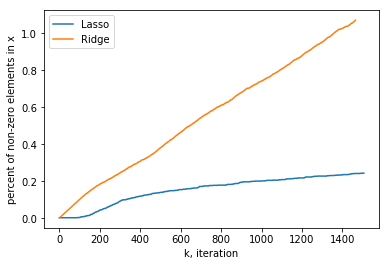

In [211]:
#semilogy(range(len(history_lasso["time"])), history_lasso["g_norm"], label = "lasso")
#show()
plot(array(history_lasso["x_sparsity"])/1000, label="Lasso")
plot(array(history["x_sparsity"])/1000, label="Ridge")
legend()
xlabel("k, iteration")
ylabel("percent of non-zero elements in x")

## 111

In [1543]:
%%time

iters_n = []
sparsity_n = []
time_n = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 12
display(progress_bar)

for i in [5, 10, 25, 50, 75, 100, 200, 300]:
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        n = i
        m = 3*n
        mu = 1/n
        x_true = rand(n)
        x_true /= sum(x_true)
        X = rand(m, n)
        y = dot(X, x_true)
        e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
        X = sparsify(array(X), e_lower_lim+0.01)

        start_point = rand(n)
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_n.append(mean(local_iters))
    sparsity_n.append(mean(local_sparsity))
    time_n.append(mean(local_time))
    progress_bar.value += 1

/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


CPU times: user 10min 43s, sys: 10.6 s, total: 10min 54s
Wall time: 15min 24s


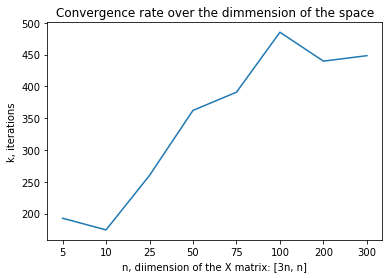

In [1544]:
plot(iters_n)
xticks(range(len(iters_n)), [5, 10, 25, 50, 75, 100, 200, 300])
xlabel("n, diimension of the X matrix: [3n, n]")
ylabel("k, iterations")
title("Convergence rate over the dimmension of the space")

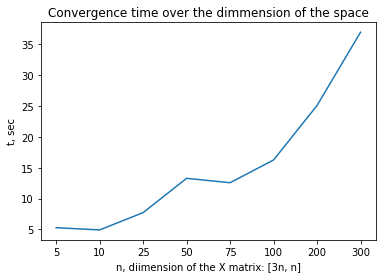

In [1545]:
plot(time_n)
xticks(range(len(iters_n)), [5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 800, 1000])
xlabel("n, diimension of the X matrix: [3n, n]")
ylabel("t, sec")
title("Convergence time over the dimmension of the space")

## Эксперименты на степень разреженности

In [1213]:
%%time

iters_s = []
sparsity_s = []
time_s = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 20
display(progress_bar)

for i in range(1, 21):
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        n = 200
        m = 3*n
        mu = 1/n
        x_true = rand(n)
        x_true /= sum(x_true)
        X = rand(m, n)
        y = dot(X, x_true)
        e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
        X = sparsify(array(X), e_lower_lim*i)

        start_point = rand(n)
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_s.append(mean(local_iters))
    sparsity_s.append(mean(local_sparsity))
    time_s.append(mean(local_time))
    progress_bar.value += 1

CPU times: user 46min 50s, sys: 50.8 s, total: 47min 41s
Wall time: 1h 39min 42s


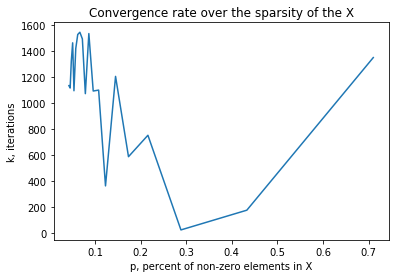

In [1253]:
plot(sparsity_s, iters_s)
xlabel("p, percent of non-zero elements in X")
ylabel("k, iterations")
title("Convergence rate over sparsity of the X")

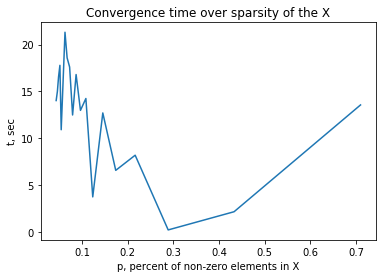

In [1254]:
plot(sparsity_s, time_s)
xlabel("p, percent of non-zero elements in X")
ylabel("t, sec")
title("Convergence time over sparsity of the X")

## Эксперимент про ассимптотики по числу строк матрицы X

In [1291]:
%%time

iters_m = []
sparsity_m = []
time_m = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 11
display(progress_bar)

for i in [20, 40, 50, 75, 100, 200, 300, 400, 500, 800, 1000]:
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        n = 10
        m = i
        mu = 1/n
        x_true = rand(n)
        x_true /= sum(x_true)
        X = rand(m, n)
        y = dot(X, x_true)
        #e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
        #X = sparsify(array(X), e_lower_lim+0.01)

        start_point = rand(n)
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_m.append(mean(local_iters))
    sparsity_m.append(mean(local_sparsity))
    time_m.append(mean(local_time))
    progress_bar.value += 1

CPU times: user 2min 14s, sys: 2.83 s, total: 2min 17s
Wall time: 1min 56s


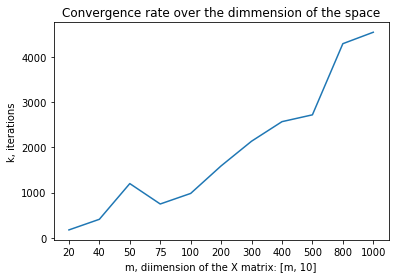

In [1294]:
plot(iters_m)
xticks(range(len(iters_m)), [20, 40, 50, 75, 100, 200, 300, 400, 500, 800, 1000])
xlabel("m, diimension of the X matrix: [m, 10]")
ylabel("k, iterations")
title("Convergence rate over the dimmension of the space")

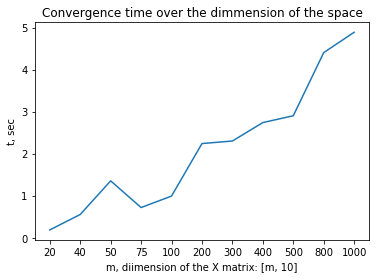

In [1293]:
plot(time_m)
xticks(range(len(iters_m)), [20, 40, 50, 75, 100, 200, 300, 400, 500, 800, 1000])
xlabel("m, diimension of the X matrix: [m, 10]")
ylabel("t, sec")
title("Convergence time over the dimmension of the space")

## Эксперимент о зависимости скорости сходимости от начального приближения

In [1295]:
%%time

iters_l = []
sparsity_l = []
time_l = []

progress_bar = FloatProgress()
progress_bar.min = 0
progress_bar.max = 20
display(progress_bar)

n = 10
m = 100
mu = 1/n
x_true = rand(n)
x_true /= sum(x_true)
X = rand(m, n)
y = dot(X, x_true)
e_lower_lim = matrix.max(matrix(abs(X)))*sqrt(n)
X = sparsify(array(X), e_lower_lim*10)
angle_point = np.zeros(n)
angle_point[0] = 1

for i in linspace(0, 1, 20):
    local_iters = []
    local_sparsity = []
    local_time = []
    
    for _ in range(5):
        start_point = i*x_true + (1-i)*angle_point
        start_point /= sum(start_point)

        start = timeit.default_timer()
        x_ccd, steps_ccd, x = CCD_sparse(X, y, mu, start_point, e = 1e-3)
        stop = timeit.default_timer()
        
        local_iters.append(steps_ccd)
        local_sparsity.append(sum(X != 0)/(n*m))
        local_time.append(stop-start)
    
    iters_l.append(mean(local_iters))
    sparsity_l.append(mean(local_sparsity))
    time_l.append(mean(local_time))
    progress_bar.value += 1

CPU times: user 3min 15s, sys: 3.37 s, total: 3min 18s
Wall time: 3min 24s


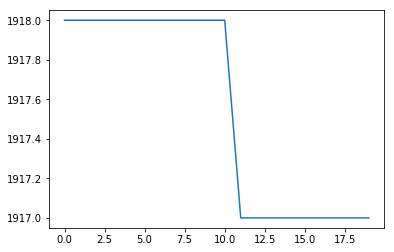

In [1296]:
plot(iters_l)

## Бэкапы

In [12]:
def f_dense(x, X, y, mu):
    return norm(dot(X, x) - y)**2 + mu/2*norm(x)**2

def grad_f_dense(x, X, y, mu):
    return 2*dot(X.T, dot(X, x) - y) + mu*x

In [184]:
def f(x, X, y, mu):
    return sparse.linalg.norm(X.dot(x) - y)**2 + mu/2*sparse.linalg.norm(x)**2

def g(x, X, y, mu):
    return 2*X.T.dot(X.dot(x.T) - y) + mu*x.T